<a href="https://colab.research.google.com/github/BhaveshJain1947/Technical-Analysis--AlgoTrading-/blob/main/Technical_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [1]:
# Download historical data from Yahoo Finance
ticker = "INDIGO.NS"  # Replace with the stock symbol of your choice
data = yf.download(ticker, start="2018-10-01", end="2023-10-01",interval='1d')

NameError: ignored

In [432]:
# Define strategy parameters
short_window = 30  # Short-term moving average
long_window = 100  # Long-term moving average

# Calculate moving averages
data['EMA30'] = data['Close'].ewm(span=short_window).mean()
data['SMA100'] = data['Close'].rolling(window=long_window).mean()

In [433]:
# Initialize variables
position = 0
buy_signals = []
sell_signals = []

num_profit_trades = 0
num_loss_trades = 0
largest_loss_trade = 0
largest_profit_trade = 0

# Implement the trading strategy
for i in range(long_window, len(data)):
    if data['EMA30'][i] > data['SMA100'][i] and position == 0:
        # Buy signal: Short-term moving average crosses above long-term moving average
        buy_signals.append(data.index[i])
        position = 1
    elif data['EMA30'][i] < data['SMA100'][i] and position == 1:
        # Sell signal: Short-term moving average crosses below long-term moving average
        sell_signals.append(data.index[i])
        position = 0

        # Calculate trade profit/loss
        trade_return = (data['Close'][i] / data['Close'][buy_signals[-1]]) - 1
        if trade_return > 0:
            num_profit_trades += 1
            nos = 100000//data['Close'][buy_signals[-1]]
            largest_profit_trade=max(largest_profit_trade, (data['Close'][i] - data['Close'][buy_signals[-1]]))
        else:
            num_loss_trades += 1

if (position == 1):
  sell_signals.append(data.index[-1])
  position = 0



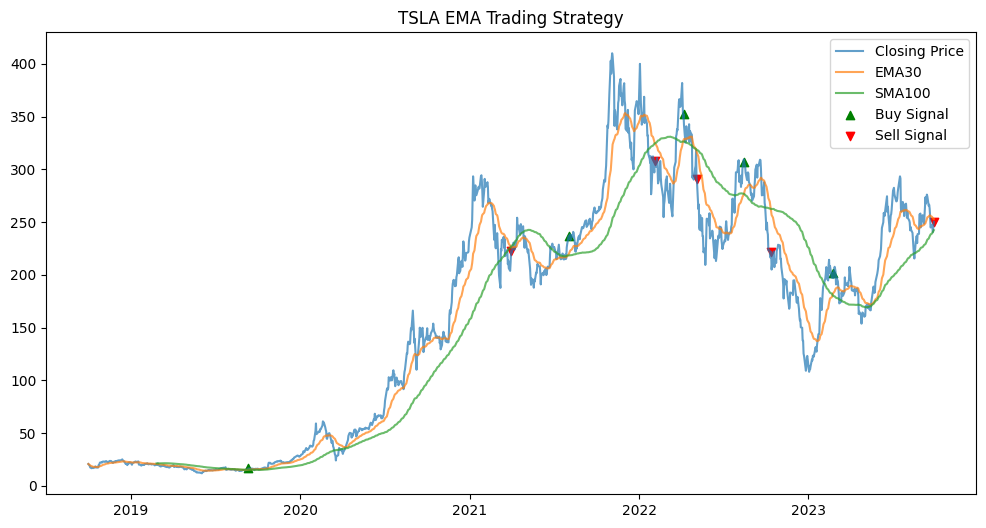

In [434]:
# Visualize the strategy
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Closing Price', alpha=0.7)
plt.plot(data.index, data['EMA30'], label='EMA30', alpha=0.7)
plt.plot(data.index, data['SMA100'], label='SMA100', alpha=0.7)
plt.scatter(buy_signals, data['Close'][buy_signals], marker='^', color='g', label='Buy Signal')
plt.scatter(sell_signals, data['Close'][sell_signals], marker='v', color='r', label='Sell Signal')
plt.legend()
plt.title(f'{ticker} EMA Trading Strategy')
plt.show()


In [435]:
# Calculate returns
returns = data['Close'].pct_change()
cumulative_returns = (1 + returns).cumprod()

# Calculate portfolio value
initial_balance = 100000  # Initial portfolio balance
balance = initial_balance
position = 0

#For CSV File
action=[]
date=[]
stock=[]
portfolio_value=[]

for i in range(len(data)):
    if data.index[i] in buy_signals:
        position = balance // data['Close'][i]
        balance -= position * data['Close'][i]
        action.append('Buy')
        date.append(data.index[i])
        stock.append(position)
        portfolio_value.append(balance)
    elif data.index[i] in sell_signals:
        balance += position * data['Close'][i]
        position = 0
        action.append('Sell')
        date.append(data.index[i])
        stock.append(position)
        portfolio_value.append(balance)

# Calculate performance metrics
total_return = (balance + position * data['Close'][-1]) / initial_balance - 1
annualized_return = (1 + total_return) ** (252 / len(data)) - 1  # Assuming 252 trading days in a year
benchmark_return = data['Close'][-1] / data['Close'][0] - 1
num_trades = len(buy_signals)
daily_returns = cumulative_returns.pct_change()
max_drawdown = (1 - cumulative_returns / cumulative_returns.cummax()).max()


In [436]:
# Print summary
print(f'Total Return: {total_return:.2%}')
print(f'Annualized Return: {annualized_return:.2%}')
print(f'Benchmark Return: {benchmark_return:.2%}')
print(f'Number of Trades: {num_trades}')
print(f'Max Drawdown: {max_drawdown:.2%}')

# Print number of profit and loss trades
print(f'Number of Profit-Making Trades: {num_profit_trades}')
print(f'Number of Loss-Making Trades: {num_loss_trades}')

Total Return: 1200.73%
Annualized Return: 67.18%
Benchmark Return: 1108.01%
Number of Trades: 5
Max Drawdown: 73.63%
Number of Profit-Making Trades: 2
Number of Loss-Making Trades: 2


In [377]:
# Save summary to CSV (EMA)
summary = pd.DataFrame({
    'Date': date,
    'Action': action,
    'No. Of Stocks': stock,
    'Portfolio Value': portfolio_value
})
summary.to_csv('summary.csv', index=False)

In [437]:
# Calculate 12-day EMA
data['EMA12'] = data['Close'].ewm(span=12, adjust=False).mean()

# Calculate 26-day EMA
data['EMA26'] = data['Close'].ewm(span=26, adjust=False).mean()

# Calculate MACD line
data['MACD'] = data['EMA12'] - data['EMA26']

# Calculate Signal Line (9-day EMA of MACD)
data['Signal Line'] = data['MACD'].ewm(span=9, adjust=False).mean()


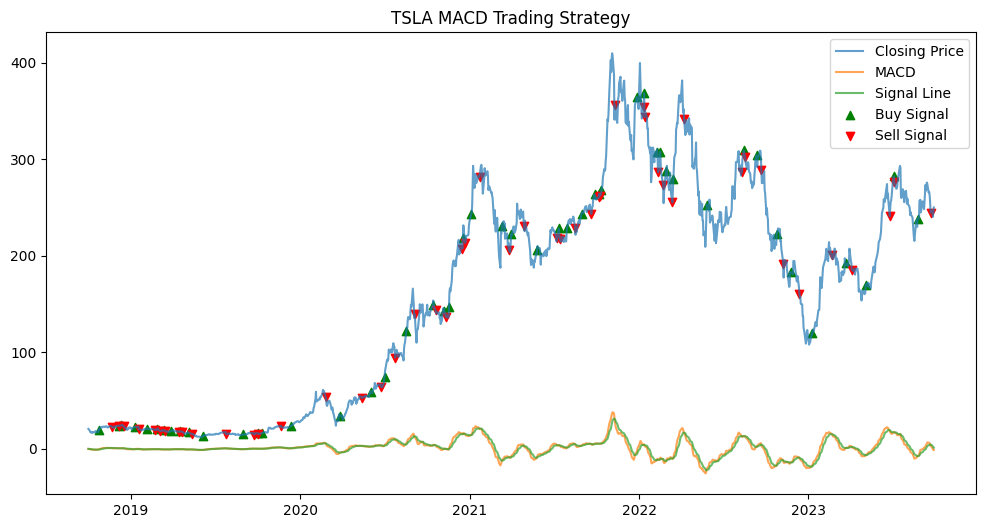

In [438]:
# Initialize variables
position = 0
buy_signals = []
sell_signals = []

num_profit_trades = 0
num_loss_trades = 0

# Implement the trading strategy
for i in range(1, len(data)):
    if data['MACD'][i] > data['Signal Line'][i] and position == 0:
        # MACD crossover above signal line - Buy signal
        buy_signals.append(data.index[i])
        position = 1
    elif data['MACD'][i] < data['Signal Line'][i] and position == 1:
        # MACD crossover below signal line - Sell signal
        sell_signals.append(data.index[i])
        position = 0

        # Calculate trade profit/loss
        trade_return = (data['Close'][i] / data['Close'][buy_signals[-1]]) - 1
        if trade_return > 0:
            num_profit_trades += 1
        else:
            num_loss_trades += 1

if (position == 1):
  sell_signals.append(data.index[-1])
  position = 0

# Visualize the strategy
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Closing Price', alpha=0.7)
plt.plot(data.index, data['MACD'], label='MACD', alpha=0.7)
plt.plot(data.index, data['Signal Line'], label='Signal Line', alpha=0.7)
plt.scatter(buy_signals, data['Close'][buy_signals], marker='^', color='g', label='Buy Signal')
plt.scatter(sell_signals, data['Close'][sell_signals], marker='v', color='r', label='Sell Signal')
plt.legend()
plt.title(f'{ticker} MACD Trading Strategy')
plt.show()



In [439]:
# Calculate returns
returns = data['Close'].pct_change()
cumulative_returns = (1 + returns).cumprod()

# Calculate portfolio value
initial_balance = 100000  # Initial portfolio balance
balance = initial_balance
position = 0

#For CSV File
action=[]
date=[]
stock=[]
portfolio_value=[]

for i in range(len(data)):
    if data.index[i] in buy_signals:
        position = balance // data['Close'][i]
        balance -= position * data['Close'][i]
        action.append('Buy')
        date.append(data.index[i])
        stock.append(position)
        portfolio_value.append(balance)
    elif data.index[i] in sell_signals:
        balance += position * data['Close'][i]
        position = 0
        action.append('Sell')
        date.append(data.index[i])
        stock.append(position)
        portfolio_value.append(balance)

# Calculate performance metrics
total_return = (balance + position * data['Close'][-1]) / initial_balance - 1
annualized_return = (1 + total_return) ** (252 / len(data)) - 1  # Assuming 252 trading days in a year
benchmark_return = data['Close'][-1] / data['Close'][0] - 1
num_trades = len(buy_signals)
daily_returns = cumulative_returns.pct_change()
max_drawdown = (1 - cumulative_returns / cumulative_returns.cummax()).max()


In [440]:
# Print summary
print(f'Total Return: {total_return:.2%}')
print(f'Annualized Return: {annualized_return:.2%}')
print(f'Benchmark Return: {benchmark_return:.2%}')
print(f'Number of Trades: {num_trades}')
print(f'Max Drawdown: {max_drawdown:.2%}')

# Print number of profit and loss trades
print(f'Number of Profit-Making Trades: {num_profit_trades}')
print(f'Number of Loss-Making Trades: {num_loss_trades}')

Total Return: 1376.56%
Annualized Return: 71.48%
Benchmark Return: 1108.01%
Number of Trades: 49
Max Drawdown: 73.63%
Number of Profit-Making Trades: 18
Number of Loss-Making Trades: 31


In [69]:
# Save summary to CSV (MACD)
summary = pd.DataFrame({
    'Date': date,
    'Action': action,
    'No. Of Stocks': stock,
    'Portfolio Value': portfolio_value
})
summary.to_csv('summary.csv', index=False)

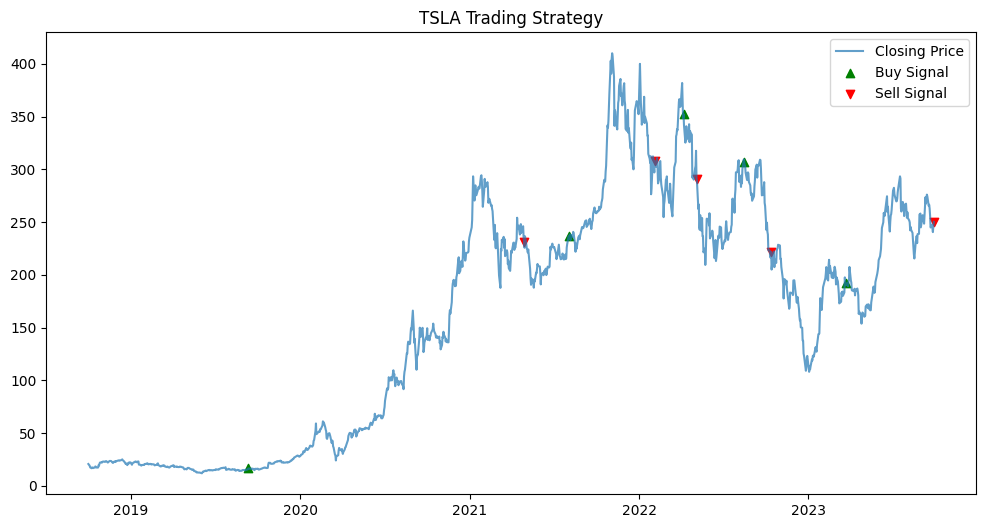

In [441]:
# EMA + MACD
# Initialize variables
position = 0
buy_signals = []
sell_signals = []
num_profit_trades = 0
num_loss_trades = 0


# Implement the trading strategy
for i in range(1, len(data)):
    if data['MACD'][i] > data['Signal Line'][i] and data['EMA30'][i] > data['SMA100'][i] and position == 0:
        # MACD crossover above signal line - Buy signal
        buy_signals.append(data.index[i])
        position = 1
    elif data['MACD'][i] < data['Signal Line'][i] and data['EMA30'][i] < data['SMA100'][i] and position == 1:
        # MACD crossover below signal line - Sell signal
        sell_signals.append(data.index[i])
        position = 0

        # Calculate trade profit/loss
        trade_return = (data['Close'][i] / data['Close'][buy_signals[-1]]) - 1
        if trade_return > 0:
            num_profit_trades += 1
        else:
            num_loss_trades += 1

if (position == 1):
  sell_signals.append(data.index[-1])
  position = 0

# Visualize the strategy
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Closing Price', alpha=0.7)
plt.scatter(buy_signals, data['Close'][buy_signals], marker='^', color='g', label='Buy Signal')
plt.scatter(sell_signals, data['Close'][sell_signals], marker='v', color='r', label='Sell Signal')
plt.legend()
plt.title(f'{ticker} Trading Strategy')
plt.show()


In [442]:
# Calculate returns
returns = data['Close'].pct_change()
cumulative_returns = (1 + returns).cumprod()

# Calculate portfolio value
initial_balance = 100000  # Initial portfolio balance
balance = initial_balance
position = 0

#For CSV File
action=[]
date=[]
stock=[]
portfolio_value=[]

for i in range(len(data)):
    if data.index[i] in buy_signals:
        position = balance // data['Close'][i]
        balance -= position * data['Close'][i]
        action.append('Buy')
        date.append(data.index[i])
        stock.append(position)
        portfolio_value.append(balance)
    elif data.index[i] in sell_signals:
        balance += position * data['Close'][i]
        position = 0
        action.append('Sell')
        date.append(data.index[i])
        stock.append(position)
        portfolio_value.append(balance)

# Calculate performance metrics
total_return = (balance + position * data['Close'][-1]) / initial_balance - 1
annualized_return = (1 + total_return) ** (252 / len(data)) - 1  # Assuming 252 trading days in a year
benchmark_return = data['Close'][-1] / data['Close'][0] - 1
num_trades = len(buy_signals)
daily_returns = cumulative_returns.pct_change()
max_drawdown = (1 - cumulative_returns / cumulative_returns.cummax()).max()


In [443]:
# Print summary
print(f'Total Return: {total_return:.2%}')
print(f'Annualized Return: {annualized_return:.2%}')
print(f'Benchmark Return: {benchmark_return:.2%}')
print(f'Number of Trades: {num_trades}')
print(f'Max Drawdown: {max_drawdown:.2%}')

# Print number of profit and loss trades
print(f'Number of Profit-Making Trades: {num_profit_trades}')
print(f'Number of Loss-Making Trades: {num_loss_trades}')

Total Return: 1321.57%
Annualized Return: 70.18%
Benchmark Return: 1108.01%
Number of Trades: 5
Max Drawdown: 73.63%
Number of Profit-Making Trades: 2
Number of Loss-Making Trades: 2


In [214]:
# Save summary to CSV (EMA + MACD)
summary = pd.DataFrame({
    'Date': date,
    'Action': action,
    'No. Of Stocks': stock,
    'Portfolio Value': portfolio_value
})
summary.to_csv('summary.csv', index=False)

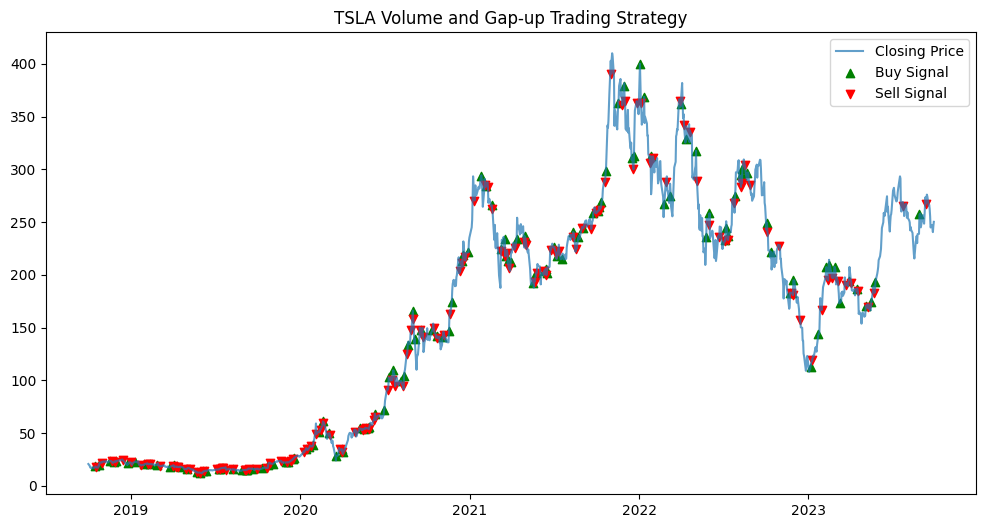

Total Return: 906.27%
Annualized Return: 58.80%
Benchmark Return: 1108.01%
Number of Trades: 131
Max Drawdown: 73.63%
Number of Profit-Making Trades: 55
Number of Loss-Making Trades: 76


In [444]:
#Momentum Trading Strategy

# Calculate daily price changes and absolute changes
data['Price Change'] = data['Close'].diff()
data['Abs Change'] = data['Price Change'].abs()

# Calculate average daily price change and volume change
lookback_period = 20
data['Avg Price Change'] = data['Abs Change'].rolling(window=lookback_period).mean()
data['Volume Change'] = data['Volume'].pct_change() * 100

# Define thresholds for signals
volume_threshold = 10  # Percentage increase in volume for momentum
price_change_threshold = 0.02  # Minimum price change for gap-up signal

# Initialize variables
position = 0
buy_signals = []
sell_signals = []
num_profit_trades = 0
num_loss_trades = 0

# Implement the trading strategy
for i in range(1, len(data)):
    if data['Volume Change'][i] > volume_threshold and data['Price Change'][i] > price_change_threshold and position == 0:
        # Increasing volume and gap-up - Buy signal
        buy_signals.append(data.index[i])
        position = 1
    elif data['Volume Change'][i] < -volume_threshold and data['Price Change'][i] < -price_change_threshold and position == 1:
        # Decreasing volume and gap-down - Sell signal
        sell_signals.append(data.index[i])
        position = 0

        # Calculate trade profit/loss
        trade_return = (data['Close'][i] / data['Close'][buy_signals[-1]]) - 1
        if trade_return > 0:
            num_profit_trades += 1
        else:
            num_loss_trades += 1

# Visualize the strategy
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Closing Price', alpha=0.7)
plt.scatter(buy_signals, data['Close'][buy_signals], marker='^', color='g', label='Buy Signal')
plt.scatter(sell_signals, data['Close'][sell_signals], marker='v', color='r', label='Sell Signal')
plt.legend()
plt.title(f'{ticker} Volume and Gap-up Trading Strategy')
plt.show()

# Calculate returns
returns = data['Close'].pct_change()
cumulative_returns = (1 + returns).cumprod()

# Calculate portfolio value
initial_balance = 100000  # Initial portfolio balance
balance = initial_balance
position = 0

#For CSV File
action=[]
date=[]
stock=[]
portfolio_value=[]

for i in range(len(data)):
    if data.index[i] in buy_signals:
        position = balance // data['Close'][i]
        balance -= position * data['Close'][i]
        action.append('Buy')
        date.append(data.index[i])
        stock.append(position)
        portfolio_value.append(balance)
    elif data.index[i] in sell_signals:
        balance += position * data['Close'][i]
        position = 0
        action.append('Sell')
        date.append(data.index[i])
        stock.append(position)
        portfolio_value.append(balance)

if (position == 1):
  sell_signals.append(data.index[-1])
  position = 0

# Calculate performance metrics
total_return = (balance + position * data['Close'][-1]) / initial_balance - 1
annualized_return = (1 + total_return) ** (252 / len(data)) - 1  # Assuming 252 trading days in a year
benchmark_return = data['Close'][-1] / data['Close'][0] - 1
num_trades = len(buy_signals)
daily_returns = cumulative_returns.pct_change()
max_drawdown = (1 - cumulative_returns / cumulative_returns.cummax()).max()

# Print summary
print(f'Total Return: {total_return:.2%}')
print(f'Annualized Return: {annualized_return:.2%}')
print(f'Benchmark Return: {benchmark_return:.2%}')
print(f'Number of Trades: {num_trades}')
print(f'Max Drawdown: {max_drawdown:.2%}')

# Print number of profit and loss trades
print(f'Number of Profit-Making Trades: {num_profit_trades}')
print(f'Number of Loss-Making Trades: {num_loss_trades}')

In [139]:
# Save summary to CSV (Momentum Strategy)
summary = pd.DataFrame({
    'Date': date,
    'Action': action,
    'No. Of Stocks': stock,
    'Portfolio Value': portfolio_value
})
summary.to_csv('summary.csv', index=False)